# PROJECT 4 - CHI CITY MOSQUITOS

- James Babyak
- Conor Barry-Hoke
- Jerome Benton
- Christopher Nowak

## Objective

Predict when and where different species of mosquitos will test positive for West Nile virus in the greater Chicago area

## TOC

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Data Transformation](#2.0-bullet)
3. [Modelling](#3.0-bullet)
4. [Output](#4.0-bullet)
5. [Kaggle Submission](#5.0-bullet)

# <a class="anchor" id="first-bullet">Imports</a>

In [1]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
'''import requests
import json'''

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

#NLP Processing
'''from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer'''

#Time analysis
import time
import datetime
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('seaborn-darkgrid')

# <a class="anchor" id="1.0-bullet"> 1. EDA</a>

Four datasets available:
- Train and test datasets of historical data for mosquitos caught in traps that tested positive for West Nile
- Weather dataset of time period across all test and train data
- Spray dataset of time and locations where mosquito control was implemented

In [2]:
data_spray = pd.read_csv('./Data/spray.csv')
data_weather = pd.read_csv('./Data/weather.csv')
data_train = pd.read_csv('./Data/train.csv')
data_test = pd.read_csv('./Data/test.csv')

In [3]:
df_train = data_train #Don't edit the initial frame. For recovery

In [4]:
#Convert to Date Time from object
df_train.loc[:, ['Date']]= pd.to_datetime(df_train['Date'])

#Switch to DateTime Index
df_train.index = df_train.Date

## 1.2 Feature Analysis

In [5]:
# 5.2% of all readings tested positive for West Nile
data_train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [6]:
# Certain Species had a higher rate of occurance than others
data_train['WnvPresent'].groupby(data_train['Species']).mean().to_frame()

,WnvPresent
Species,
CULEX ERRATICUS,0.000000
CULEX PIPIENS,0.088922
CULEX PIPIENS/RESTUANS,0.055135
CULEX RESTUANS,0.017883
CULEX SALINARIUS,0.000000
CULEX TARSALIS,0.000000
CULEX TERRITANS,0.000000


In [7]:
# Count of mosquito occurred by species
data_train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [8]:
# Top ten traps by occurance of West Nile testing positive
trap_freq = data_train[['WnvPresent']].groupby([data_train['Trap']]).sum().sort_values('WnvPresent', ascending=False).head(10)
trap_freq

,WnvPresent
Trap,
T900,66
T115,41
T002,18
T138,16
T003,14
T011,11
T225,11
T128,11
T903,10


In [9]:
#Top ten traps account for 38% of total occurences
trap_freq.sum() / data_train['WnvPresent'].sum()

WnvPresent    0.377495
dtype: float64

### 1.2.1 West Nile Yearly Trends

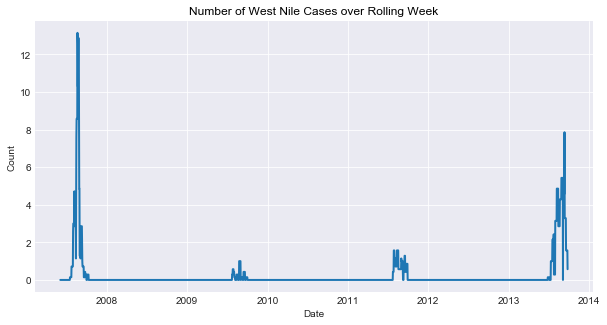

In [10]:
# 2007 and 2013 had more occurances of west nile than 2009 and 2011
plt.figure(figsize=(10,5))
plt.plot(df_train['WnvPresent'].resample('D').sum().rolling(window=7).mean(), alpha=1, lw=2)
plt.title("Number of West Nile Cases over Rolling Week", loc='Center', fontsize=12, fontweight=0, color='black')
plt.xlabel("Date")
plt.ylabel("Count");

### 1.2.2 Additional Feature Research after Initial Model

# <a class="anchor" id="2.0-bullet">2. Data Transformation </a>

## 2.1 Weather Slice

There are two weather stations in the main weather file: 1 for O'hare and 2 for Midway.
O'hare is a more complete dataset, so we will start by using only this location.

In [11]:
weather_station_1 = data_weather.loc[data_weather.Station==1, :]
weather_station_2 = data_weather.loc[data_weather.Station==2, :]

In [12]:
weather_station_1 = weather_station_1.drop('Station', axis=1)
weather_station_2 = weather_station_2.drop('Station', axis=1)

In [13]:
# Convert Date to datetime format 
weather_station_1.loc[:, ['Date']] = pd.to_datetime(weather_station_1.Date)
weather_station_2.loc[:, ['Date']] = pd.to_datetime(weather_station_2.Date)

In [14]:
# Set index to Date
weather_station_1.index = weather_station_1.Date
weather_station_2.index = weather_station_2.Date

## 2.2 Weather Convert Objects

In [15]:
# Convert Avg Temperature to float
weather_station_1.loc[:, ['Tavg']] = weather_station_1['Tavg'].astype('float64')

In [16]:
# Convert Trace amount of rainfall and Precip from 'T' to value
weather_station_1.loc[:, ['PrecipTotal']] = \
weather_station_1['PrecipTotal'].map(lambda x: .001 if x=='  T' else x).astype(float)
weather_station_1.loc[:, ['SnowFall']] = \
weather_station_1['SnowFall'].map(lambda x: .001 if x=='  T' else x).astype(float)

In [17]:
# Drop unecessary columns
weather_station_1 = weather_station_1.drop('Depart', axis=1)
weather_station_1 = weather_station_1.drop('Water1', axis=1)

In [18]:
# There are three columns with a 'M' that will need to be replaced
weather_station_1[weather_station_1 == 'M'].count()

Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        3
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
SnowFall       0
PrecipTotal    0
StnPressure    2
SeaLevel       5
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [19]:
# ONLY RUN THIS CELL ONCE
#find means without 'M' values and fill in blank - less than 5 for each
stnpressure_mean = weather_station_1[weather_station_1['StnPressure']!='M']['StnPressure'].astype(float).mean()
sealevel_mean = weather_station_1[weather_station_1['SeaLevel']!='M']['SeaLevel'].astype(float).mean()
wetbulb_mean = weather_station_1[weather_station_1['WetBulb']!='M']['WetBulb'].astype(float).mean()

#Replace M with mean, leave others alone
weather_station_1.loc[:, 'StnPressure'] = \
weather_station_1['StnPressure'].map(lambda x: stnpressure_mean if x=='M' else x).astype(float);

weather_station_1.loc[:, 'SeaLevel'] = \
weather_station_1['SeaLevel'].map(lambda x: sealevel_mean if x=='M' else x).astype(float)

weather_station_1.loc[:, 'WetBulb'] = \
weather_station_1['WetBulb'].map(lambda x: wetbulb_mean if x=='M' else x).astype(float);

## 2.3 Complete Weather dataframe

In [20]:
weather_station_1.head()

,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,
2007-05-01,2007-05-01,83,50,67.0,51,56.0,0,2,0448,1849,,0,0.0,0.000,29.10,29.82,1.7,27,9.2
2007-05-02,2007-05-02,59,42,51.0,42,47.0,14,0,0447,1850,BR,0,0.0,0.000,29.38,30.09,13.0,4,13.4
2007-05-03,2007-05-03,66,46,56.0,40,48.0,9,0,0446,1851,,0,0.0,0.000,29.39,30.12,11.7,7,11.9
2007-05-04,2007-05-04,66,49,58.0,41,50.0,7,0,0444,1852,RA,0,0.0,0.001,29.31,30.05,10.4,8,10.8
2007-05-05,2007-05-05,66,53,60.0,38,49.0,5,0,0443,1853,,0,0.0,0.001,29.40,30.10,11.7,7,12.0


### 2.3.1 Addition Weather Features

In [21]:
#Create dummy columns for weather codes

#list all columns
templist = [element for element in weather_station_1['CodeSum'].str.split(' ').tolist()]
newl = []
#get all tags
for element in templist:
    for subelement in element:
        newl.append(subelement)
Codes_list = list(set(newl))
Codes_list.pop(0)

#Create new columns and score 1 if present in original CodeSum value
for code in Codes_list:
    weather_station_1.loc[:, code] = weather_station_1['CodeSum'].str.contains(code)*1
weather_station_1 = weather_station_1.drop('CodeSum', axis=1)

In [22]:
#Convert remaining cols to float. Leftover errors from station 2
obj_cols = [col for col in weather_station_1.columns if weather_station_1[col].dtype=='object']
for col in weather_station_1:
    if col in obj_cols:
        weather_station_1.loc[:, col] = weather_station_1[col].astype('float64')

### 2.3.2 Weather Station 2 (not necessary)

In [23]:
weather_station_2 = weather_station_2.drop(['Depart', 'Depth', 'Water1', 'SnowFall'], axis=1)

In [24]:
Mcols=[]
for col in weather_station_2.columns:
    try:
        if weather_station_2[weather_station_2[col]=='M'].shape[0] > 0:
            print('   ', col, weather_station_2[weather_station_2[col]=='M'].shape[0])
            Mcols.append(col)
    except:
        next

    Tavg 11
    WetBulb 1
    Heat 11
    Cool 11
    PrecipTotal 2
    StnPressure 2
    SeaLevel 4
    AvgSpeed 3


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [25]:
# Convert Trace amount of rainfall and Precip from 'T' to value
weather_station_2.loc[:, ['PrecipTotal']] = \
weather_station_2['PrecipTotal'].map(lambda x: .005 if x=='  T' else x)

In [26]:
for col in Mcols:
    tempmean =  weather_station_2[weather_station_2[col]!='M'][col].astype(float).mean()
    weather_station_2.loc[:, col] = \
weather_station_2[col].map(lambda x: tempmean if x=='M' else x).astype(float)

In [27]:
#Create dummy columns for weather codes

#list all columns
templist = [element for element in weather_station_2['CodeSum'].str.split(' ').tolist()]
newl = []
#get all tags
for element in templist:
    for subelement in element:
        newl.append(subelement)
Codes_list = list(set(newl))
Codes_list.pop(0)

#Create new columns and score 1 if present in original CodeSum value
for code in Codes_list:
    weather_station_2.loc[:, code] = weather_station_2['CodeSum'].str.contains(code)*1
weather_station_2 = weather_station_2.drop('CodeSum', axis=1)
#Not using these anyway
weather_station_2 = weather_station_2.drop(['Sunrise', 'Sunset'], axis=1)

## 2.2 Training Data Munging

We will need to combine the train and test data with relevant addtional information for the weather and spray datasets.

This will be done by combine dataset using the index after it has been set to the date.


### 2.2.1 Time Series

#### 2.2.1.1 Basic Conversion

In [28]:
#Create Days from start column for easy analysis
BeginDate = datetime.date(2007, 4, 30)
df_train.loc[:, 'DaysFrom'] = df_train.index - pd.to_datetime(BeginDate)
#extract date number from datetime entry. Should capture broad time dependence
df_train.loc[:, 'DaysFrom'] = df_train['DaysFrom'].astype(str).str.replace(' days 00:00:00.000000000', '').astype(int)
#Extract Month information
df_train.loc[:, 'Month'] = df_train.index.month

In [29]:
#Add measurement in for YearDay 
df_train['YearDay'] = df_train.index.dayofyear

#### 2.2.1.2 Seasonal Adjustments to Baseline Probability

In [30]:
#Create a normalized graph to observe seasonality across years
year_day = pd.DataFrame(df_train.index.dayofyear)
year_day['Wnv'] = pd.DataFrame(df_train['WnvPresent']).reset_index().drop('Date', axis=1)
#Total number of occurences by day of the year
daily_sums = year_day.groupby(by='Date').sum()

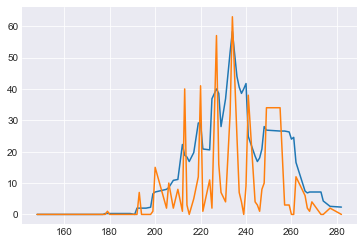

In [31]:
#Shift up two days to capture Friday-Monday jump
#2 seems to be an appropriate normalization factor
normizer = 2
rolls = pd.Series([daily_sums.iloc[row-5:row+2].mean().sum()*normizer for row in range(len(daily_sums))])
rolls.index = daily_sums.index
plt.plot(rolls)
plt.plot(year_day.groupby(by='Date').sum());#confirm this is from skipped weekends or something

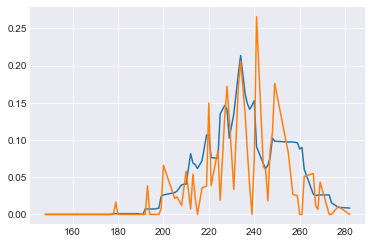

In [32]:
#Normalize by total rows used in calculation
rolling_count = year_day.groupby(by='Date').count()
rolling_average_rate = rolls / rolling_count['Wnv'].mean()/normizer
plt.plot( rolling_average_rate)
plt.plot(year_day.groupby(by='Date').sum() /rolling_count)

In [33]:
# Create
rolling_average_rate = pd.DataFrame(rolling_average_rate, columns=['seasonal_baseline'])

In [34]:
"""In the above, I assume the drop offs in frequency are generally due 
to anomolies in the collection method, as opposed to true changes. 
In any event, we need a complete set of predicted probabilities for all dates in the
range, include those missing in the training set. By fitting a curve,
we are able to fill in the blanks programatically"""
mu, std = sp.stats.norm.fit(list(rolls.index))

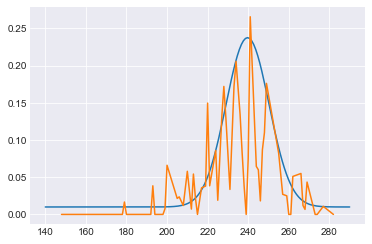

In [35]:
"""This is graphed here for a reason. 
the following variables are pure manual calibration to get what I want.
6: raise max
25: shift center to match actual date distrubtion
3.5: tighten up the standard deviation
.01: increase baseline to catch relative outliers."""

norm_list = []
#Min and max dates in train and test data
_min = 140
_max = 290
for i in range(_min, _max):
    norm_list.append(6*sp.stats.norm.pdf(i-25, mu, std/3.5)+.01)

plt.plot(np.linspace(_min, _max, len(norm_list)), norm_list)
plt.plot(year_day.groupby(by='Date').sum() /rolling_count)

In [36]:
seasonal_dict = {}
for i in range(len(norm_list)):
    seasonal_dict[140+i] = norm_list[i]

### 2.2.2 Combine with weather data

In [37]:
#Create rolling average for all weather columns.
weather_rolling_7 = weather_station_1.resample('D').sum().rolling(window=7).mean().shift()
weather_rolling_14 = weather_station_1.resample('D').sum().rolling(window=7).mean().shift()


In [38]:
#Weather Data on different rolling averages, this will be referenced later in fine tuning
weather_rolling_1 = weather_station_1.resample('D').sum()
weather_rolling_5 = weather_station_1.resample('D').sum().rolling(window=5).mean().shift()
weather_rolling_10 = weather_station_1.resample('D').sum().rolling(window=10).mean().shift()
weather_rolling_15 = weather_station_1.resample('D').sum().rolling(window=15).mean().shift()
weather_rolling_20 = weather_station_1.resample('D').sum().rolling(window=20).mean().shift()

In [39]:
#Weather data on different rolling totals, used for precipitation totals
weather_rain_1 = weather_station_1.resample('D').sum()
weather_rain_5 = weather_station_1.resample('D').sum().rolling(window=5).sum().shift()
weather_rain_10 = weather_station_1.resample('D').sum().rolling(window=10).sum().shift()
weather_rain_15 = weather_station_1.resample('D').sum().rolling(window=15).sum().shift()
weather_rain_20 = weather_station_1.resample('D').sum().rolling(window=20).sum().shift()

### 2.2.3 Dummy Columns

In [40]:
df_species_dummies = pd.get_dummies(df_train['Species'])
df_trap_dummies = pd.get_dummies(df_train['Trap'])

## 2.3 Final Concatention

In [41]:
#CAUTION: JOINING DATAFRAMES IS MEMORY INTENSIVE

In [42]:
#YOU HAVE BEEN WARNED

In [43]:
#Using left join to only include weather rows that are in training set
weather_rolling_formodel = weather_rolling_15

df_combined = df_train.join(weather_rolling_formodel, how='left')

In [44]:
"""Question: should trap dummies be included alongside longitude / latitude?
Possible overfit."""

'Question: should trap dummies be included alongside longitude / latitude?\nPossible overfit.'

In [45]:
# First run
df_combined = pd.concat([df_combined,df_species_dummies, df_trap_dummies], axis=1)

In [46]:
cols_to_drop = ['Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'AddressAccuracy', 'Date']
df_combined = df_combined.drop(cols_to_drop, axis=1)

# <a class="anchor" id="3.0-bullet">3. Model </a>

### 3.0.1 Analysis Setup

In [47]:
# Function that makes confusion matrix and outputs ROC score
def make_pretty_conmat(y_test, predictions):
    conmat = confusion_matrix(y_test, predictions)
    conmat_df = pd.DataFrame(conmat, columns=['Predicted 0', 'Pred 1'], index=['Actual 0', 'Actual 1'])
    conmat_df = conmat_df.add_prefix('Predicted: ')
    print(f"ROC score: {roc_auc_score(y_test, predictions)}")
    return conmat_df

In [48]:
# Runs and outputs results into dataframe of any model input along with train/test data
def roc_calculate(model,X_train,y_train,X_test, y_test):
    df_roc = pd.DataFrame(columns=['models','train', 'test'])
    for mod in range(0,len(model)):
        # Set and fit model from list
        use_model = model[mod]
        use_model.fit(X_train,y_train)
        # Create predictions
        y_train_predicted = use_model.predict_proba(X_train)
        y_test_predicted = use_model.predict_proba(X_test)
        #Isolate positive prediction values 
        wnv_train_preds = [proba[1] for proba in y_train_predicted]
        wnv_test_preds = [proba[1] for proba in y_test_predicted]
        #Score and save value
        train = roc_auc_score(y_train, wnv_train_preds)
        test = roc_auc_score(y_test, wnv_test_preds)
        # Set name and add to dataframe
        name = str(model[mod])
        df_roc.loc[len(df_roc)] = [name, train, test]
    return df_roc

In [49]:
#def Im_a_function_use_me()
##get wnv predictors
#proba_array = [proba[1] for proba in our_model.predict_proba(X_test)]
##find seasonal adjustment from year day
#adj_score = pd.Series(X_test.index.dayofyear, index=X_test.index).map(lambda x: seasonal_dict[x])

#print('   base: ', roc_auc_score(y_test, proba_array))
#print('   seasonal: ', roc_auc_score(y_test, proba_array + adj_score))

## 3.1 Initial Model

In [90]:
#Most weather columns show evidence of overfit
weather_cols = list(weather_rolling_formodel.columns)

# Set columns to exlude from features matrix
cols_to_exclude = ['Date','WnvPresent', 'NumMosquitos', 'DaysFrom', 
                   'Sunrise', 'Sunset',  'StationNum', 'Depth', 'SN',
                   'Month', 'seasonal_baseline','Address',
                   'Species', 'Block','Street','Trap', 'AddressAccuracy', 'AddressNumberAndStreet', 
                   'Latitude', 'Longitude'
                  ]
for element in weather_rolling_formodel.columns:
    if element not in weather_cols:
        cols_to_exclude.append(element)
model_cols = [col for col in df_combined.columns if col not in cols_to_exclude]

In [91]:
# Set X and y matrices
X = df_combined.loc[:, model_cols]
y = df_train['WnvPresent']

In [92]:
"""This normalization is done to allow flexible and recoverable transformations.
For example, if cols_to_normalize is set to weather_cols,
only those columns will be normalized. 
Inclusion should depend upon model selected."""
cols_to_normalize = model_cols
norm_dict = {}
for col in cols_to_normalize:
    _df_cur = X.loc[:, col]
    _mean = _df_cur.mean()
    _std = _df_cur.std()
    #Store for test data transform
    norm_dict[col] = [_mean, _std]

    X.loc[:, col] = (X.loc[:, col] - _mean) / _std

In [93]:
print(list(X.columns))

['YearDay', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'BR', 'HZ', 'SQ', 'TS', 'BCFG', 'FG+', 'VCTS', 'FG', 'TSRA', 'MIFG', 'RA', 'FU', 'DZ', 'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS', 'T001', 'T002', 'T003', 'T004', 'T005', 'T006', 'T007', 'T008', 'T009', 'T011', 'T012', 'T013', 'T014', 'T015', 'T016', 'T017', 'T018', 'T019', 'T025', 'T027', 'T028', 'T030', 'T031', 'T033', 'T034', 'T035', 'T036', 'T037', 'T039', 'T040', 'T043', 'T044', 'T045', 'T046', 'T047', 'T048', 'T049', 'T050', 'T051', 'T054', 'T054C', 'T060', 'T061', 'T062', 'T063', 'T065', 'T066', 'T067', 'T069', 'T070', 'T071', 'T072', 'T073', 'T074', 'T075', 'T076', 'T077', 'T078', 'T079', 'T080', 'T081', 'T082', 'T083', 'T084', 'T085', 'T086', 'T088', 'T089', 'T090', 'T091', 'T092', 'T094', 'T094B', 'T095', 'T096', 'T097

In [94]:
#Stratification on Days From should ensure usable spread in time data. Should get most periods in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X.index, random_state=42)

In [95]:
# List of initial classifiers to review
classifiers = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(n_neighbors=8),
    BaggingClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    SVC(probability=True)]

In [96]:
# This baseline model input features are:
# 1) As is Weather Data (no rolling)
# 2) Location only by cordianates
# 3) Dummy by Species
# 4) Dummy by Trap Name
roc_calculate(classifiers,X_train,y_train,X_test,y_test)

,models,train,test
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.878722,0.832935
1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.907889,0.739234
2,"BaggingClassifier(base_estimator=None, bootstr...",0.990522,0.728645
3,"RandomForestClassifier(bootstrap=True, class_w...",0.991688,0.693049
4,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.865877,0.828413
5,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.953768,0.773706


We will focus on two models: Logistic Regression and SVC

## 3.2 Model with Feature Engineering

### Correcting Overfitting

In [57]:
def train_data_update(df_list,exclude_list=cols_to_exclude, 
                      weather_list=weather_cols, 
                      df_train=df_train, 
                      weather=weather_rolling_formodel):

    df_combine = df_train.join(weather, how='left')
    all_dfs = [df_combine]
    all_dfs.extend(df_list)
    df_combine = pd.concat(all_dfs, axis=1)
    
    for element in weather.columns:
        if element not in weather_list:
            exclude_list.append(element) # add element if it is not in the exclude weather list
    
    model_cols = [col for col in df_combine.columns if col not in exclude_list]

    X = df_combine.loc[:, model_cols]
    y = df_train['WnvPresent']
    
    #This normalization is done to allow flexible and recoverable transformations.
    #For example, if cols_to_normalize is set to weather_cols, only those columns will be normalized. 
    #Inclusion should depend upon model selected.
    
    norm_dict = {}
    for col in model_cols:
        _df_cur = X.loc[:, col]
        _mean = _df_cur.mean()
        _std = _df_cur.std()
        #Store for test data transform
        norm_dict[col] = [_mean, _std]

        X.loc[:, col] = (X.loc[:, col] - _mean) / _std

    #Stratification on Days From should ensure usable spread in time data. Should get most periods in train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X.index, random_state=42)

    print(list(X.columns))
    return X, y, model_cols, norm_dict

In [58]:
#Most weather columns show evidence of overfit
weather_cols = list(weather_rolling_formodel.columns)

# Set columns to exlude from features matrix
cols_to_exclude = ['Date','WnvPresent', 'NumMosquitos', 'DaysFrom', 
                   'Sunrise', 'Sunset',  'StationNum', 'Depth', 'SN', 'seasonal_baseline','Address',
                   'Species', 'Block','Street','Trap', 'AddressAccuracy', 'AddressNumberAndStreet',
                   'CULEX PIPIENS'
                  ]
dummies_to_combine = [df_species_dummies]

X, y, model_cols, norm_dict = train_data_update(dummies_to_combine,weather_list=weather_cols,weather=weather_rolling_formodel)

['Latitude', 'Longitude', 'YearDay', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'BR', 'HZ', 'SQ', 'TS', 'BCFG', 'FG+', 'VCTS', 'FG', 'TSRA', 'MIFG', 'RA', 'FU', 'DZ', 'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS']


### Jerome SVC Model

### Weather Optimization 

In [98]:
# Optimizing Which Weather rolling averages or totals to use

def Rolling_weather_finder(combos, model_list):
    #Initia and clear relevant dataframes
    df_combined = pd.DataFrame()
    df_weather_roc = pd.DataFrame()
    df_combo = pd.DataFrame(columns=['Tmax','DewPoint','WetBulb','PrecipTotal'])

    for i in range(0,len(combos)):
        # This for loop is for Tmax
        T_max_df = "weather_rolling_"+str(combos[i])
        df_tmax = eval(T_max_df)
        for j in range(0,len(combos)):
            # This for loop is for Dewpoint
            dewpoint_df = "weather_rolling_"+str(combos[j])
            df_dewpoint = eval(dewpoint_df)
            for k in range(0,len(combos)):
                # This for loop is for Rain Total
                rain_df = "weather_rain_"+str(combos[k])
                df_rain = eval(rain_df)
                for l in range(0,len(combos)):
                    # This for loop is for WetBulb
                    wetbulb_df = "weather_rolling_"+str(combos[l])
                    df_wetbulb = eval(wetbulb_df)

                    # Recreate Weather dataframe
                    weather_df = pd.DataFrame()
                    weather_df['Tmax'] = df_tmax['Tmax']
                    weather_df['Dewpoint'] = df_dewpoint['DewPoint']
                    weather_df['PrecipTotal'] = df_rain['PrecipTotal']
                    weather_df['WetBulb'] = df_wetbulb['WetBulb']
                    weather_df = weather_df[weather_df['Tmax'] != 0]
                    weather_df['Tmax'].fillna(weather_df['Tmax'].mean(), inplace=True)
                    weather_df['Dewpoint'].fillna(weather_df['Dewpoint'].mean(), inplace=True)
                    weather_df['PrecipTotal'].fillna(weather_df['PrecipTotal'].min(), inplace=True)
                    weather_df['WetBulb'].fillna(weather_df['WetBulb'].mean(), inplace=True)

                    # Combine to other non weather features
                    df_for_model = df_train.join(weather_df, how='left')
                    df_for_model = pd.concat([df_for_model,df_species_dummies], axis=1)
                    model_cols = [col for col in df_for_model.columns if col not in cols_to_exclude]

                    # Set X and y matrices
                    X = df_for_model.loc[:, model_cols]
                    y = df_train['WnvPresent']
                    # Train Test Split Data
                    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X.index, random_state=42)

                    #Set and Run Model (uses roc_calc function to run and add results to dataframe)
                    # example setup for model list: model = [AdaBoostClassifier(random_state=42)]
                    df_weather_roc = df_weather_roc.append(roc_calculate(model_list,X_train,y_train,X_test,y_test))
                    # Log place
                    df_combo.loc[len(df_combo)] = [combos[i], combos[j], combos[l], combos[k]]
    
    df_weather_roc.reset_index(inplace=True)
    df_weather_roc = pd.concat([df_weather_roc, df_combo], axis=1)
    return df_weather_roc

In [ ]:
%% time
# SELECTING THE RIGHT WEATHER COMBINATION FOR the LR Model
combos = [20,5,10,15] # rolling average to try
models = [LogisticRegression()]
output_df_lr = Rolling_weather_finder(combos,models)

In [100]:
output_df_lr.sort_values('test', ascending=False).head(5)

,index,models,train,test,Tmax,DewPoint,WetBulb,PrecipTotal
142,0,"LogisticRegression(C=1.0, class_weight=None, d...",0.759492,0.782176,10,20,10,15
32,0,"LogisticRegression(C=1.0, class_weight=None, d...",0.759845,0.781751,20,10,20,20
224,0,"LogisticRegression(C=1.0, class_weight=None, d...",0.759845,0.781751,15,10,20,20
130,0,"LogisticRegression(C=1.0, class_weight=None, d...",0.756396,0.781018,10,20,10,20
208,0,"LogisticRegression(C=1.0, class_weight=None, d...",0.759046,0.779876,15,5,20,20


In [61]:
# SELECTING THE RIGHT WEATHER COMBINATION FOR the SVC Model
combos = [1,5,10,15,20] # rolling average to try
models = [SVC(probability=True)]
output_df_svc = Rolling_weather_finder(combos,models)
output_df_svc.sort_values('test', ascending=False).head(5)

,index,models,train,test,Tmax,DewPoint,WetBulb,PrecipTotal
110,0,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.717136,0.687488,20,10,20,1
4,0,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.631817,0.672208,1,1,20,20
113,0,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.705090,0.662975,20,10,20,15
3,0,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.646059,0.659954,1,1,20,15
111,0,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.716639,0.655256,20,10,20,5


In [62]:
# make below a function 

In [63]:
top_value = 15 #index location
model_to_use = output_df_lr
#Using left join to only include weather rows that are in training set
weather_rolling_formodel['Tmax'] = eval("weather_rolling_"+str(model_to_use.iloc[top_value].Tmax)).Tmax
weather_rolling_formodel['DewPoint'] = eval("weather_rolling_"+str(model_to_use.iloc[top_value].DewPoint)).DewPoint
weather_rolling_formodel['WetBulb'] = eval("weather_rolling_"+str(model_to_use.iloc[top_value].WetBulb)).WetBulb
weather_rolling_formodel['PrecipTotal'] = eval("weather_rain_"+str(model_to_use.iloc[top_value].PrecipTotal)).PrecipTotal

weather_rolling_formodel['Tmax'].fillna(weather_rolling_formodel['Tmax'].mean(), inplace=True)
weather_rolling_formodel['DewPoint'].fillna(weather_rolling_formodel['DewPoint'].mean(), inplace=True)
weather_rolling_formodel['PrecipTotal'].fillna(weather_rolling_formodel['PrecipTotal'].min(), inplace=True)
weather_rolling_formodel['WetBulb'].fillna(weather_rolling_formodel['WetBulb'].mean(), inplace=True)

X, y, model_cols, norm_dict = train_data_update(dummies_to_combine,
                                     weather_list=weather_cols,
                                     weather=weather_rolling_formodel)

['Latitude', 'Longitude', 'YearDay', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'BR', 'HZ', 'SQ', 'TS', 'BCFG', 'FG+', 'VCTS', 'FG', 'TSRA', 'MIFG', 'RA', 'FU', 'DZ', 'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS']


In [64]:

#Stratification on Days From should ensure usable spread in time data. Should get most periods in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X.index, random_state=42)

## 3.3 Model Tuning

In [65]:
def grid_search(parameterz,model,X_train=X_train,y_train=y_train):
    gs = GridSearchCV(model,param_grid=parameterz)
    gs.fit(X_train, y_train);
    print(gs.best_params_)
    return gs

In [66]:
# Use grid search function and save results for Logistic Regression
paramz_lr = {
    'penalty': ['l2'],
    'C': [.01, .02],
    'solver' : ['liblinear', 'newton-cg', 'lbfgs']
}
lr = LogisticRegression(random_state=1)
gs_lr = grid_search(paramz_lr,lr)

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


In [67]:
# Use grid search function and save results for SVC
paramz_svc = {
    'C': [0.1, 0.5, 1],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}
svc = SVC(probability=True)
gs_svc = grid_search(paramz_svc,svc)

{'C': 0.1, 'kernel': 'linear'}


In [68]:
# Use grid search function and save results for ADA
#paramz_ada = {'n_estimators': [45,50,55]}
#ada = AdaBoostClassifier(random_state=42)
#gs_ada = grid_search(paramz_ada,ada)

## 3.3 Final Model Selection

In [69]:
our_model = gs_lr

In [70]:
#get wnv predictors
proba_array = [proba[1] for proba in our_model.predict_proba(X_test)]
#find seasonal adjustment from year day
adj_score = pd.Series(X_test.index.dayofyear, index=X_test.index).map(lambda x: seasonal_dict[x])

print('   base: ', roc_auc_score(y_test, proba_array))
print('   seasonal: ', roc_auc_score(y_test, proba_array + adj_score))

   base:  0.8152102031176193
   seasonal:  0.7971713579149184


# <a class="anchor" id="4.0-bullet">4. Output</a>

## 4.1 Transform test data

In [71]:
df_test = data_test
df_test.shape

(116293, 11)

### 4.1.1 Time Series

In [72]:
#Convert to Date Time from object
df_test.loc[:, ['Date']]= pd.to_datetime(df_test['Date'])

#Switch to DateTime Index
df_test.index = df_test.Date

#Create Days from start column for easy analysis

df_test.loc[:, 'DaysFrom'] = df_test.index - pd.to_datetime(BeginDate)
#extract date number from datetime entry. Should capture broad time dependence
df_test.loc[:, 'DaysFrom'] = df_test['DaysFrom'].astype(str).str.replace(' days 00:00:00.000000000', '').astype(int)
#Extract Month information
df_test.loc[:, 'Month'] = df_test.index.month

#Include yearday for seasonal adjustment later
df_test['YearDay'] = df_test.index.dayofyear

In [73]:
#Get weekday dummies and add to test sit ---> IF WEEKDAY FEATURE USED <----
'''df_test_weekday = pd.get_dummies(df_test.index.weekday_name)
df_test_weekday.index = df_test.index
df_test = pd.concat([df_test, df_test_weekday], axis=1)''';

In [74]:
#Need to do some math to include seasonality here. Some yeardays in test not in training.

### 4.1.2 Categorical

In [75]:
df_test_species = pd.get_dummies(df_test['Species'])
# Check and print list of species in train data but not in test data
species_to_drop = [col for col in df_test_species.columns if col not in df_species_dummies.columns]
print(species_to_drop)

['UNSPECIFIED CULEX']


In [76]:
# If any species needs to be dropped, it will be done here before added to test datset
df_test_species = df_test_species.drop(species_to_drop, axis=1)
df_test = pd.concat([df_test,df_test_species], axis=1)

In [77]:
# Create dummy list of trap from test data and add back in
df_test_trap = pd.get_dummies(df_test['Trap'])
df_test = pd.concat([df_test,df_test_trap], axis=1)

### 4.1.3 Weather

In [78]:
df_test = df_test.join(weather_rolling_formodel, how='left')

### 4.1.4 Drops

In [79]:
df_test = df_test.drop(cols_to_drop, axis=1)

#  <a class="anchor" id="5.0-bullet">5. Kaggle Submission</a>

## 5.1 Fit to Test Data

In [80]:
# Check to see if there is a mismatch in test data with train data, if anything will appear in the list
df_test_X = df_test.loc[:, model_cols]
[col for col in df_test_X.columns if col not in X.columns]

[]

In [81]:
# Recall normalizer from before
for col in model_cols:
    _mean = norm_dict[col][0]
    _std = norm_dict[col][1]
    #Store for test data transform
    #norm_dict[col] = [_mean, _std]

    df_test_X.loc[:, col] = (df_test_X.loc[:, col] - _mean) / _std

In [82]:
df_test_preds = our_model.predict(df_test_X)

In [83]:
df_test_prob_array = our_model.predict_proba(df_test_X)
df_test_probas = [proba[1] for proba in df_test_prob_array]

In [84]:
df_test_preds_adj =pd.Series(df_test_X.index.dayofyear, index=df_test_X.index).map(lambda x: seasonal_dict[x])

## 5.2 Assess

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


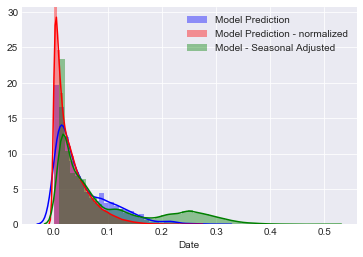

In [85]:
sns.distplot([proba[1] for proba in our_model.predict_proba(X_test)], color='blue', label='Model Prediction') #Train - test
sns.distplot(df_test_probas, color='red', label='Model Prediction - normalized') #Test -Test before adjustment
sns.distplot(df_test_preds_adj+df_test_probas, color='green', label='Model - Seasonal Adjusted') #Test -Test with adjustment
plt.legend()


In [86]:
print('   base model WNV predicitons: ', df_test_preds.sum())
print('   adusted proba WNV predictions: ', sum(df_test_preds_adj))
print('   predicted rate WNV adjusted: ', sum(df_test_preds_adj)/len(df_test_preds_adj))

   base model WNV predicitons:  0
   adusted proba WNV predictions:  7443.0995313341555
   predicted rate WNV adjusted:  0.06400298841146204


## 5.3 Create Submission File

In [87]:
df_outputs = pd.DataFrame(df_test.Id)
df_outputs['WnvPresent'] = df_test_probas #+ df_test_preds_adj #Simply 0 out if inappropriate
df_outputs = df_outputs.reset_index().drop('Date', axis=1)

In [88]:
now_month = datetime.datetime.now().month
now_day = datetime.datetime.now().day
now_hour = datetime.datetime.now().hour
now_minute = datetime.datetime.now().minute
output_title = './Predictions_{}.{}_{}{}.csv'.format(now_month, now_day, now_hour, now_minute)

In [89]:
df_outputs.to_csv(output_title, index=False)